ℹ️  SciPy no está instalado: se usará interpolación lineal.


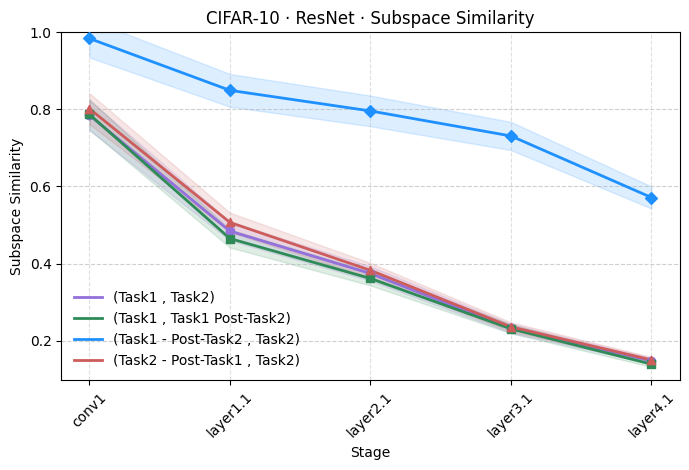

✅  Figura guardada como 'subspace_similarity.png'


In [2]:
#!/usr/bin/env python3
# subspace_plot.py  –  Traza SubspaceSim capa por capa (rango Y automático)

import json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ────────────────────────── 1. Suavizado opcional ─────────────────────────────
try:
    from scipy.interpolate import CubicSpline
    _CS = True
except ImportError:
    print("ℹ️  SciPy no está instalado: se usará interpolación lineal.")
    _CS = False

# ────────────────────────── 2. Archivos JSON ──────────────────────────────────
files = {
    "(Task1 , Task2)":               "sim_t1ck1_vs_t2ck2d.json",
    "(Task1 , Task1 Post-Task2)":    "sim_t1ck1_vs_t1ck2d.json",
    "(Task1 - Post-Task2 , Task2)":  "sim_t1ck2_vs_t2ck2d.json",
    "(Task2 - Post-Task1 , Task2)":  "sim_t2ck1_vs_t2ck2d.json"
}

stage_order = ["backbone.conv1", "backbone.layer1.1",
               "backbone.layer2.1", "backbone.layer3.1",
               "backbone.layer4.1"]

common, raw = None, {}
for lab, path in files.items():
    with open(path) as f:
        layers = json.load(f)["layers"]
    raw[lab] = layers
    common = set(layers) if common is None else common & layers.keys()

layers_full = [l for l in stage_order if l in common]
curves = {lab: np.array([raw[lab][k] for k in layers_full]) for lab in raw}

orig_x  = np.arange(len(layers_full))
dense_x = np.linspace(orig_x[0], orig_x[-1], len(layers_full) * 3 - 2)
layers_short = [l.replace("backbone.", "") for l in layers_full]

# ────────────────────────── 3. Estilo ─────────────────────────────────────────
markers = ["o", "s", "D", "^"]
colors  = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
colors = ["mediumpurple", "seagreen", "dodgerblue", "indianred"]

plt.figure(figsize=(7, 4.8))

for i, (lab, y) in enumerate(curves.items()):
    col, mark = colors[i % len(colors)], markers[i % len(markers)]
    y_dense = CubicSpline(orig_x, y)(dense_x) if _CS and len(y) >= 3 else np.interp(dense_x, orig_x, y)

    plt.plot(dense_x, y_dense, lw=2, label=lab, color=col)
    plt.scatter(orig_x, y, marker=mark, color=col, zorder=3)
    plt.fill_between(dense_x, y_dense*0.95, y_dense*1.05, color=col, alpha=0.15)

# ────────────────────────── 4. Escalado del eje Y ─────────────────────────────
# ► Opción 1: rango fijo 0‒1 (similar al paper)
# plt.ylim(0, 1)

# ► Opción 2: rango automático con margen de 5 %
y_vals = np.concatenate(list(curves.values()))
ymin, ymax = y_vals.min(), y_vals.max()
margin = 0.05 * (ymax - ymin if ymax != ymin else 1)
plt.ylim(max(0, ymin - margin), min(1, ymax + margin))  # tope 0–1 por seguridad

# ────────────────────────── 5. Decoración ─────────────────────────────────────
plt.grid(True, axis="both", ls="--", alpha=0.4)

plt.xticks(orig_x, layers_short, rotation=45)
plt.xlabel("Stage");  plt.ylabel("Subspace Similarity")
plt.title("CIFAR-10 · ResNet · Subspace Similarity")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("subspace_similarity.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅  Figura guardada como 'subspace_similarity.png'")
